# RAW DATA CLEANING

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# import utils functions
%run utils.ipynb

In [2]:
lyrics_df = pd.read_csv("./data/lyrics.csv")
lyrics_df.shape

(50466, 6)

In [3]:
lyrics_df.loc[lyrics_df.artist == "Bruce Springsteen", :]

,artist,song,album,release_date,genre,lyrics
5251,Bruce Springsteen,I'm On Fire,Born in the U.S.A.,1984-06-04,Rock,"Hey, little girl, is your daddy home? Did he ..."
5252,Bruce Springsteen,Thunder Road,Born to Run,1975-08-25,Rock,"The screen door slams, Mary's dress waves Like..."
5253,Bruce Springsteen,Blinded By The Light,"Greetings From Asbury Park, N.J.",1973-01-05,Rock,Madman drummers bummers and Indians in the su...
5254,Bruce Springsteen,Born To Run,Born to Run,1975-08-25,Rock,"In the day, we sweat it out on the streets Of ..."
5255,Bruce Springsteen,The River,The River,NaN,Rock,"I come from down in the valley Where, miste..."
5256,Bruce Springsteen,Dancing In The Dark,Born in the U.S.A.,1984-05-03,Rock,I get up in the evening And I ain't got nothi...
5257,Bruce Springsteen,Badlands,Darkness on the Edge of Town,1978-06-02,Rock,"Lights out tonight, trouble in the heartland ..."
5258,Bruce Springsteen,Rosalita (come Out Tonight),"The Wild, the Innocent & the E Street Shuffle",1973-09-11,Rock,"Spread out now, Rosie, doctor come cut loose ..."
5259,Bruce Springsteen,Better Days,Lucky Town,1992-03-31,Rock,Well my soul checked out missing as I sat lis...
5260,Bruce Springsteen,Hungry Heart,The River,1980-10-17,Rock,"Got a wife and kids in Baltimore, Jack I went..."


## 1. Drop NaNs in *lyrics* column

Although I've already tried to catch unavailable lyrics during the data retrieval process (see `retrieve_lyrics(*args*)` in `lyrics_scraping.ipynb`), a quick inspection of the dataset outlines the presence of a few NaNs. This is mainly due to two reasons: 
1. first, there was a very rare server connection error that occurred while scraping and this caused some lyrics to be set to NaN while the exception was handled;
2. second, and most importantly, the site from which I gathered artists and song titles (*MetroLyrics*) apparently duplicated some artists starting with "The" (e.g., *The Beatles* were classified both in letter B and also in letter T). This someway caused the appearance of most of the uncaught NaNs in some of the duplicated artists. 

In [4]:
lyrics_null = lyrics_df[lyrics_df.lyrics.isnull()]
lyrics_null.shape

(1554, 6)

In [5]:
artists_null = sorted(
    [(lyrics_null[lyrics_null.artist == artist].shape[0], artist) for artist in lyrics_null.artist.unique()],
    key=lambda x: x[0], reverse=True
    )
print("lyrics_NaNs", "artist")
artists_null[:20]

lyrics_NaNs artist


[(79, 'The Cure'),
 (77, 'The Animals'),
 (75, 'The Beatles'),
 (75, 'The Carpenters'),
 (75, 'The Rolling Stones'),
 (75, 'The Killers'),
 (75, 'The Cranberries'),
 (75, 'The Muppets'),
 (75, 'The Hit Crew'),
 (75, 'The Lonely Island'),
 (72, 'The Chainsmokers'),
 (56, 'The Lumineers'),
 (49, 'The High Kings'),
 (45, 'The Phantom of the Opera (Original London Cast)'),
 (45, 'The Platters'),
 (35, 'Hans Zimmer'),
 (26, 'Yanni'),
 (21, 'Steven Universe'),
 (20, 'Quincy Jones'),
 (18, 'The Irish Descendants')]

In [6]:
lyrics_df = lyrics_df.loc[lyrics_df.lyrics.notnull(), :]
lyrics_df.shape

(48912, 6)

## 2. Drop lyrics with nonsensical length

In order not to negatively influence the analysis of the lyrics, it's important to drop those instances which show lengths that are completely unrealistic given the type of the data. A quick inspection reveals that for some unspecified reason the *Genius* API I used has a few nonsensical instances, such as lyrics long up to 150000 tokens, or as short as 20 tokens.

I found a good rule of thumb by plotting the length distribution (the plot on the left serves as proof that there is at least one lyrics that is incredibly long, since the axis stops at 150000). Assuming that an average lyrics line contains at least 5 to 10 words, I dropped all instances with `len < 30`, i.e. approximately less than 3 to 6 lines. As for the upper bound I dropped all lyrics with more than 2000 tokens.

Since the above only aims at dropping instances which are clearly not lyrics and at homogenizing data, I decided to do it directly on the raw dataset, without a preliminary deletion of punctuation. 

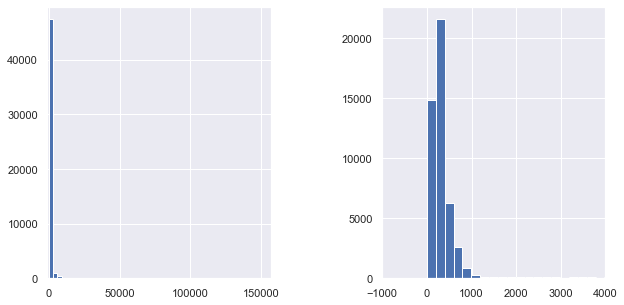

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(lyrics_df.lyrics.apply(lambda text: len(text.split())), bins=50)
ax[0].set_xlim(left=-1000)
ax[1].hist(lyrics_df.lyrics.apply(lambda text: len(text.split())), bins=750)
ax[1].set_xlim(left=-1000, right=4000)
plt.subplots_adjust(wspace=0.5)
plt.show()

In [8]:
lyrics_df.loc[lyrics_df.lyrics.apply(lambda text: len(text.split())) > 2000, :].shape

(2009, 6)

In [9]:
lyrics_df.loc[lyrics_df.lyrics.apply(lambda text: len(text.split())) < 30, :].shape

(533, 6)

In [10]:
lyrics_df = lyrics_df.loc[
                (lyrics_df.lyrics.apply(lambda text: len(text.split())) < 2000) &
                (lyrics_df.lyrics.apply(lambda text: len(text.split())) > 30)
                ]
lyrics_df.shape

(46357, 6)

## 3. Lyrics language

Lyrics whose language was not English have already been dropped during the retrieval process (see `retrieve_lyrics(*args*)` in `lyrics_scraping.ipynb`)

## 4. Drop duplicates

Two types of duplicates need to be dropped in order to perform a coherent analysis:
1. Possible duplicates of (artist, song) couples, due to repetitions in *MetroLyrics*' database

In [11]:
lyrics_df.loc[lyrics_df.duplicated(subset=["artist", "song"], keep="first"), :].shape

(676, 6)

In [12]:
lyrics_df.drop_duplicates(subset=["artist", "song"], keep="first", inplace=True)

2. Covers of other songs

In [13]:
lyrics_df.loc[lyrics_df.duplicated(subset=["lyrics"], keep="first"), :].shape

(1836, 6)

In [14]:
lyrics_df.drop_duplicates(subset="lyrics", keep="first", inplace=True)

## 5. Manual checks

Quickly scrolling the dataset I noticed that there are two names for Beyoncé: Beyoncé and Beyoncé-Knowles. It makes sense to rename the latter and drop duplicates

In [15]:
lyrics_df.loc[lyrics_df.artist == "Beyonce Knowles", "artist"] = "Beyoncé"

In [16]:
lyrics_df.loc[lyrics_df.duplicated(subset=["artist", "song"], keep="first"), :].shape

(1, 6)

In [17]:
lyrics_df.drop_duplicates(subset=["artist", "song"], keep="first", inplace=True)

In [18]:
lyrics_df.shape

(43844, 6)

# ANNOTATION

For the purposes of my analysis, I have downloaded two labels along with the lyrics: 
1. Musical genre: provided by *MetroLyrics* by web scraping
2. Release date: provided by *Genius* API

## 1. Genre

By plotting the distribution of genres across songs it is clear that *Rock*, *Pop* and *Hip-Hop* are the most prevalent genres. Given that there are around 8000 unclassified lyrics, I would like to annotate them in order obtain the full picture and not lose any data point. Moreover, I inspected the artists-genre pairs and uncovered some misclassifications that I am going to correct manually.

In [19]:
genres = [genre if isinstance(genre, float) is False else "None" for genre in lyrics_df.loc[:, "genre"].to_numpy()]

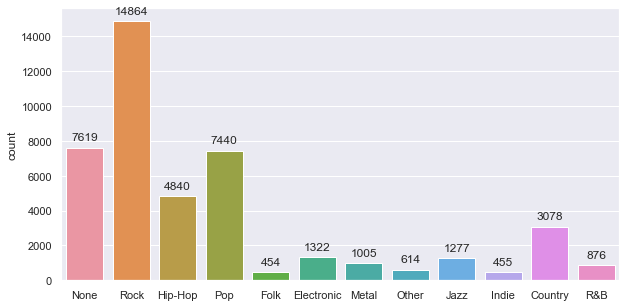

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(genres, ax=ax)
add_value_labels(ax=ax)

### Manual corrections of misclassifications

In [21]:
corrected_genres = {"Metal": ["Deep Purple", "Iron Maiden", 'Metallica', 'Rammstein'],
                      "Pop": ['Alanis Morissette', 'Gwen Stefani', 'Gary Jules', 'Il Volo', 'Of Monsters And Men', 'Sugar free'], 
                      "Indie": ['Foster The People', 'Gotye', 'HOZIER'],
                      "Folk": ['Joan Baez'], 
                      "Other": ['Soundtrack'], 
                      "R&B": ['Tina Turner', 'Zucchero']
                     }

In [22]:
for genre, artists in corrected_genres.items():
    for artist in artists:
        lyrics_df.loc[lyrics_df.artist == artist, "genre"] = [genre]*lyrics_df.loc[lyrics_df.artist == artist, "genre"].shape[0]

### NaNs annotation

In [23]:
lyrics_df.loc[lyrics_df.genre.isnull(), "artist"].unique()

array(['6ix9ine', '50 Cent', '2Pac', '30 Seconds to Mars', '6cyclemind',
       '5 Seconds Of Summer', '2Face Idibia', '3 Piece', 'ABBA', 'Adele',
       'A. R. Rahman', 'Annie', 'Aladdin', 'Aizat Amdan',
       'Andrea Bocelli', 'Anthony Brown & Group Therapy',
       'Andrew Lloyd Webber', 'Ariel Rivera', 'Brett Young',
       'The Beatles', 'Bruno Mars', 'Ben&Ben', 'Brian McKnight',
       'Bob Marley', 'Byron Cage', 'Coldplay', 'Children Songs',
       'Céline Dion', 'The Carpenters', 'CupcakKe', 'Christina Perri',
       'Christmas Carols', 'Christmas Song', 'Charlie Puth',
       'Charles Jenkins', 'A Chorus Line', 'Cedarmont Kids', 'Cabaret',
       'Drake', 'Disney', 'Demi Lovato', 'DJ Khaled', 'Dolly Parton',
       'David Bowie', 'Dora The Explorer', 'Dreamgirls', 'Ed Sheeran',
       'Eminem', 'Elton John', 'Ella Fitzgerald', 'Elvis Presley',
       'Eraserheads', 'Earth Wind & Fire', 'Enya', 'Frank Sinatra',
       'Fleetwood Mac', 'Fiona Apple', 'Foo Fighters', 'Fall Out B

In [24]:
# mapping between genre to artists
genre_to_artist = {
    "Hip-Hop": ['6ix9ine', '50 Cent', '2Pac', 'Drake', 'DJ Khaled', 'Eminem', 'Kanye West', 'Lil Wayne', 'Nicki Minaj', 'XXXTENTACION', 'CupcakKe', 'Quavo', 'YoungBoy Never Broke Again', 'YG'], 
    "Rock": ['Green Day', '30 Seconds to Mars', 'Linkin Park', 'The Rolling Stones', 'David Bowie', 'Elton John', 'Elvis Presley', 'U2', 'Eraserheads', 'Hale', 'Fall Out Boy', 'Fleetwood Mac', 'Parokya Ni Edgar', 'Van Morrison', 'Foo Fighters', 'Prince', 'Queen', 'Rivermaya', 'Urban Dub', 'Vashawn Mitchell', 'Valli Frankie'], 
    "Pop": ['Maroon 5', 'Michael Jackson', 'OneRepublic', 'Harry Styles', 'Rihanna', 'One Direction', 'Idina Menzel', 'Jass Manak', 'IV Of Spades', 'Gipsy Kings', 'Fiona Apple', 'Gary Valenciano', 'Morissette Amon', 'Christina Perri', 'zain bhikha', 'Guru Randhawa', 'Ariel Rivera', 'Victorious Cast', '5 Seconds Of Summer', 'Miley Cyrus', 'We Three', 'Yo Yo Honey Singh', 'Yung Raja', 'Yeng Constantino', 'Westlife', 'Sabyan Gambus', 'Regine Velasquez', 'Velasquez Regine', 'Mariah Carey', 'Aizat Amdan', 'Katy Perry', 'Vanessa Hudgens', 'Justin Bieber', 'K. K.', 'Lady GaGa', 'Zac Efron', 'Taylor Swift', 'Oasis', 'Jason Mraz', 'Whitney Houston', 'Ed Sheeran', '6cyclemind', 'Orange And Lemons', 'ABBA', 'Luis Fonsi', 'Adele', 'Andrea Bocelli', 'The Beatles', 'Bruno Mars', 'Coldplay', 'Luciano Pavarotti', 'Céline Dion', 'Martin Nievera', 'The Carpenters', 'Demi Lovato', 'Imagine Dragons'],
    "Other": ['Disney', 'Aladdin', 'Christmas Carols', 'Jesus Christ Superstar', 'Company - Into the Woods', "Gilligan's Island",  'Cabaret', 'VeggieTales', 'A Chorus Line', 'The King And I', 'SpongeBob SquarePants', 'Little Shop Of Horrors', 'Pitch Perfect', 'Miss Saigon', 'RENT', 'South Park', 'Annie', 'LION KING',  '3 Piece', 'Yuvan Shankar Raja', 'Vishal Dadlani', 'Vicente Fernandez', 'Sesame Street', 'Sound Of Music', 'Raffi', 'Music Man', 'Christmas Song', 'Yanni', 'The Yogscast', 'US Marine Corps', 'Tv Theme', 'Scooby Doo Theme Songs', 'My Fair Lady', 'X Factor (UK)', 'X Factor (US)', 'Ran', 'Westside Story', 'Oscar Isaac', 'Quest', 'Wrestling', 'Wizard Of Oz', 'Newsies-Original Broadway Cast', 'Peterpan', 'Simpsons', 'The Phantom of the Opera (Original London Cast)', 'Neha Kakkar', 'Nawab', 'Phineas and Ferb', 'Pokémon', 'Unknown', 'Original Broadway Cast Recording', 'Dora The Explorer', 'Enya', 'Children Songs', 'Monty Python', 'Meryl Streep', 'Grease', 'Happy Birthday', 'Hans Zimmer'],
    "Reggae": ['Bob Marley', 'Ziggy Marley', '2Face Idibia', 'Ub40'],
    "Gospel": ['Lynda Randle', 'Andrew Lloyd Webber', 'Hezekiah Walker', 'Howard Shore', 'Israel', 'Byron Cage', 'Israel Houghton', 'J J Hairston & Youthful Praise', 'Fred Hammond', 'Dreamgirls', 'Hillsong United', 'Hillsong', 'James Weldon Johnson', 'Yolanda Adams', 'Charles Jenkins', 'Kirk Franklin', 'Cedarmont Kids', 'Tasha Cobbs', 'Gaither Vocal Band', 'A. R. Rahman', 'Anthony Brown & Group Therapy'],
    "Jazz": ['Ella Fitzgerald', 'Frank Sinatra'],
    "R&B": ['Earth Wind & Fire', 'Ne-Yo', 'Usher', 'Brian McKnight', 'Charlie Puth', 'India Arie', "The O'Jays", 'Queen Naija', 'Zayn Malik', 'Zack Knight', 'Zhavia Ward'],
    "Country": ['Johnny Cash', 'Brett Young', 'Dolly Parton', 'Garth Brooks', 'Hank Williams', 'Hillary Scott', 'Jimmy Buffett', 'Kenny Chesney', 'Willie Nelson', 'Zac Brown Band'], 
    "Metal": ['Ozzy Osbourne', 'Queens of The Stone Age', 'Quiet riot'], 
    "Indie": ['Ben&Ben', 'Pheobe', 'The Xx'],
    "Folk": ['Irish Rovers', 'Xavier Rudd'],
    "Electronic": ['Oliver', 'WICKED CREW']
}

In [25]:
# update dataset with new genres annotations
for genre in tqdm(genre_to_artist.keys()):
    for artist in genre_to_artist[genre]:
        lyrics_df.loc[lyrics_df.artist == artist, "genre"] = genre

100%|██████████| 13/13 [00:07<00:00,  3.93it/s]


In [26]:
lyrics_df.loc[lyrics_df.genre.isnull(), "artist"].shape

(0,)

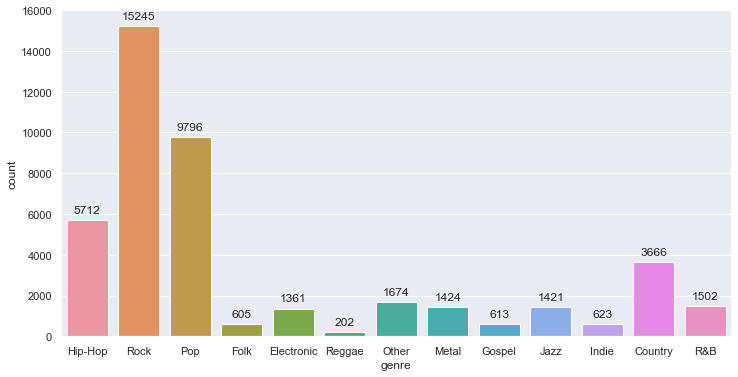

In [27]:
genres_complete = lyrics_df.genre
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(genres_complete, ax=ax)
add_value_labels(ax=ax)

## 2. Release date 

Release dates for each song have been donwloaded using the *Genius* API. Unfortunately, around a third of them are missing, therefore I would like to fill the NaNs in a coherent way according to each artist, both manually and automatically, dividing the criterion among artists that have no dates for their songs and artists that have at least some dates.

In [28]:
lyrics_df.loc[lyrics_df.release_date.isnull(), :].shape

(16460, 6)

In [29]:
# create "year" column. Month and Day are not useful for the purposes of the analysis
lyrics_df.loc[:, "year"] = None
lyrics_df.loc[lyrics_df.release_date.notnull(), "year"] = \
        lyrics_df.loc[lyrics_df.release_date.notnull(), "release_date"].apply(lambda date: datetime.strptime(date, "%Y-%m-%d").year)

In [30]:
# set to None any year before 1900 and greater than 2020 --> clearly a mistake
lyrics_df = lyrics_df.astype({"year": float})
lyrics_df.loc[(lyrics_df.year < 1900) | (lyrics_df.year > 2020), "year"] = None

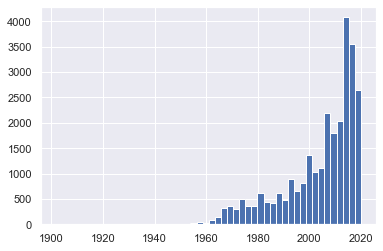

In [31]:
before_annotation = lyrics_df.loc[lyrics_df.year.notnull(), "year"]
plt.hist(before_annotation, bins=50)
plt.show()

### Artists with no dates at all

There are some artists for which no song has its release date. Since these amount to 74 musicians in total, I decided to annotate them by hand. The analysis will be concerned with the evolution over time of topics, writing styles and genres, therefore the level of granularity provided by a manual annotation of the year of each song would not result in a significant increase of information for my purposes.

Nonetheless, an ideal annotation would obviously take into account the years of activity of an artist. Therefore I decided to search for them on the web and then label the songs according to a uniform probability over the years of activity of the artists.

In [32]:
all_year_nan_artists = []
for artist in lyrics_df.artist.unique():
    artist_df = lyrics_df.loc[(lyrics_df.artist == artist), :]
    artist_df_length = artist_df.loc[:, "year"].shape[0]
    count_year_nans = artist_df.loc[:, "year"].isnull().sum()
    # if n° NaNs equals n° of rows
    if count_year_nans == artist_df_length:
        all_year_nan_artists.append((artist, artist_df_length))
len(all_year_nan_artists)

74

In [33]:
all_year_nan_artists

[('7horse', 1),
 ('A. R. Rahman', 1),
 ('Andrew E', 2),
 ('Ariel Rivera', 5),
 ('Original Cast of "Cats"', 20),
 ('Cedarmont Kids', 8),
 ('Dr. Tumi', 2),
 ('December Avenue', 1),
 ('Edith Piaf', 3),
 ('Fairport Convention', 46),
 ('Frankie Laine', 35),
 ('Frazey Ford', 17),
 ('Gary Valenciano', 16),
 ('Soweto Gospel Choir', 1),
 ('Gipsy Kings', 1),
 ('Glenn Fredly', 1),
 ('Gerry And The Pacemakers', 35),
 ('Gyroscope', 32),
 ('Irish Rovers', 25),
 ('The Irish Descendants', 3),
 ('Imago', 1),
 ('iLe', 1),
 ('Iyeoka', 10),
 ('Johnny Rebel', 2),
 ('JAY-R', 2),
 ('James Weldon Johnson', 2),
 ('Kamikazee', 1),
 ('Luciano Pavarotti', 9),
 ('Lynda Randle', 4),
 ('Martin Nievera', 21),
 ('Mocca', 26),
 ('Nawab', 1),
 ('Neha Kakkar', 1),
 ('Nana Mouskouri', 32),
 ('Opus', 3),
 ('The Phantom of the Opera (Original London Cast)', 1),
 ('Petra', 70),
 ('Quindon Tarver', 2),
 ('Queen Ifrica', 2),
 ('Question Mark & The Mysterians', 2),
 ('Qntal', 3),
 ('Quorthon', 22),
 ('Quincy Punx', 39),
 ('The 

In [34]:
artist_years_mapping = {
    '7horse': np.random.choice([year for year in range(2011, 2021)], size=1),
    'A. R. Rahman': np.random.choice([year for year in range(1992, 2021)], size=1),
    'Andrew E': np.random.choice([year for year in range(1985, 2021)], size=2),
    'Ariel Rivera': np.random.choice([year for year in range(1989, 2021)], size=5),
    'Original Cast of "Cats"': 2019*np.ones(shape=20),
    'Cedarmont Kids': np.random.choice([year for year in range(1993, 2000)], size=8),
    'Dr. Tumi': np.random.choice([year for year in range(2010, 2021)], size=2),
    'December Avenue': np.random.choice([year for year in range(2007, 2021)], size=1),
    'Edith Piaf': np.random.choice([year for year in range(1935, 1964)], size=3),
    'Fairport Convention': np.random.choice([year for year in range(1967, 2000)], size=46),
    'Frankie Laine': np.random.choice([year for year in range(1932, 1976)], size=35),
    'Frazey Ford': np.random.choice([year for year in range(2001, 2021)], size=17),
    'Gary Valenciano': np.random.choice([year for year in range(1982, 2021)], size=16),
    'Soweto Gospel Choir': np.random.choice([year for year in range(2005, 2019)], size=1),
    'Gipsy Kings': np.random.choice([year for year in range(1978, 2019)], size=1),
    'Glenn Fredly': np.random.choice([year for year in range(1995, 2021)], size=1),
    'Gerry And The Pacemakers': np.random.choice([year for year in range(1959, 1974)], size=35),
    'Gyroscope': np.random.choice([year for year in range(1997, 2021)], size=32),
    'Irish Rovers': np.random.choice([year for year in range(1967, 2012)], size=25),
    'The Irish Descendants': np.random.choice([year for year in range(1991, 2007)], size=3),
    'Imago': np.random.choice([year for year in range(1997, 2021)], size=1),
    'iLe': np.random.choice([year for year in range(2004, 2021)], size=1),
    'Iyeoka': np.random.choice([year for year in range(1996, 2021)], size=10),
    'Johnny Rebel': np.random.choice([year for year in range(1966, 2003)], size=2),
    'JAY-R': np.random.choice([year for year in range(1997, 2021)], size=2),
    'James Weldon Johnson': np.random.choice([year for year in range(1940, 1960)], size=2),
    'Kamikazee': np.random.choice([year for year in range(2000, 2015)], size=1),
    'Luciano Pavarotti': np.random.choice([year for year in range(1980, 2000)], size=9),
    'Lynda Randle': np.random.choice([year for year in range(2003, 2016)], size=4),
    'Martin Nievera': np.random.choice([year for year in range(1982, 2021)], size=21),
    'Mocca': np.random.choice([year for year in range(1997, 2021)], size=26),
    'Nawab': np.array([2019]),
    'Neha Kakkar': np.random.choice([year for year in range(2006, 2021)], size=1),
    'Nana Mouskouri': np.random.choice([year for year in range(1958, 2008)], size=32),
    'Opus': np.random.choice([year for year in range(1973, 2004)], size=3),
    'The Phantom of the Opera (Original London Cast)': np.array([1988]),
    'Petra': np.random.choice([year for year in range(1973, 2006)], size=70),
    'Quindon Tarver': np.random.choice([year for year in range(1996, 2021)], size=2),
    'Queen Ifrica': np.random.choice([year for year in range(1995, 2021)], size=2),
    'Question Mark & The Mysterians': np.random.choice([year for year in range(1966, 2000)], size=2),
    'Qntal': np.random.choice([year for year in range(1991, 2021)], size=3),
    'Quorthon': np.random.choice([year for year in range(1984, 2004)], size=22),
    'Quincy Punx': np.random.choice([year for year in range(1990, 2021)], size=39),
    'The Quakes': np.random.choice([year for year in range(1986, 2021)], size=1),
    'Reed Foehl': np.random.choice([year for year in range(2004, 2021)], size=1),
    'Sugar free': np.random.choice([year for year in range(2000, 2021)], size=1),
    'Silent Sanctuary': np.random.choice([year for year in range(2001, 2021)], size=1),
    'Songs For Children': np.random.choice([year for year in range(1980, 2021)], size=2),
    'Samsons': np.random.choice([year for year in range(1977, 2002)], size=21),
    'Toni Gonzaga': np.random.choice([year for year in range(2001, 2021)], size=10),
    'Ted Gärdestad': np.random.choice([year for year in range(1972, 1994)], size=6),
    'Typecast': np.random.choice([year for year in range(1999, 2021)], size=32),
    'Urban Dub': np.random.choice([year for year in range(2000, 2021)], size=22),
    'US Marine Corps': np.random.choice([year for year in range(1940, 2021)], size=1),
    'The Undertones': np.random.choice([year for year in range(1974, 2013)], size=26),
    'Velasquez Regine': np.random.choice([year for year in range(1986, 2021)], size=33),
    'Vaya Con Dios': np.random.choice([year for year in range(1986, 2009)], size=45),
    'Valli Frankie': np.random.choice([year for year in range(1953, 2021)], size=2),
    'Chorus of Winnie The Pooh': np.random.choice([year for year in range(2000, 2021)], size=1),
    'Wolfgang': np.random.choice([year for year in range(1992, 2021)], size=10),
    'The Wolfe Tones': np.random.choice([year for year in range(1963, 2021)], size=10),
    'X Factor (UK)': np.random.choice([year for year in range(2010, 2021)], size=4),
    'X-Perience': np.random.choice([year for year in range(1995, 2007)], size=20),
    'Ximena Sarinana': np.random.choice([year for year in range(1994, 2021)], size=10),
    'X-Pose': np.array([2019]),
    'xikidi': np.array([2015]),
    'Xiao Yu': np.random.choice([year for year in range(2003, 2021)], size=1),
    'Xasthur': np.random.choice([year for year in range(1995, 2021)], size=14),
    'Xmal Deutschland': np.random.choice([year for year in range(1980, 1990)], size=3),
    'x factor finalists': np.random.choice([year for year in range(2010, 2021)], size=1),
    'Yngwie Malmsteen': np.random.choice([year for year in range(1978, 2021)], size=67),
    'Yusuf Islam': np.random.choice([year for year in range(1995, 2017)], size=20),
    'Yiruma': np.random.choice([year for year in range(2001, 2021)], size=1),
    'zain bhikha': np.random.choice([year for year in range(1990, 2021)], size=2),
}

As an example of the result, Yusuf Islam (previously known as Cat Stevens) has been musically active (publising albums) under this name from 1995 to 2017. Indeed, after he became muslim in 1977 he changed his name and stopped performing since 1980. The last cell of this section shows the labels obtained with the method described above, which are perfectly coherent with the musical activity of this artist.

In [35]:
lyrics_df.loc[lyrics_df.artist == "Yusuf Islam", :]

,artist,song,album,release_date,genre,lyrics,year
48494,Yusuf Islam,A' Is For Allah,Footsteps in the Light,NaN,Folk,"A' is for Allah, nothing but Allah Ba is the b...",NaN
48495,Yusuf Islam,Thinking 'Bout You,Roadsinger,NaN,Folk,"Islam When I hold her hand, I could fly zilli...",NaN
48496,Yusuf Islam,Heaven/Where True Love Goes,An Other Cup,NaN,Folk,The moment you walked inside my door I knew th...,NaN
48497,Yusuf Islam,Don't Let Me Be Misunderstood,An Other Cup,NaN,Folk,"Baby, do you understand me now Sometimes I fee...",NaN
48498,Yusuf Islam,Roadsinger,Roadsinger,NaN,Folk,"Islam Roadsinger came to town, long cape and ...",NaN
48499,Yusuf Islam,Welcome Home,Roadsinger,NaN,Folk,"Saw a sign on the path ""All seekers this way"" ...",NaN
48500,Yusuf Islam,Maybe There's A World,An Other Cup,NaN,Folk,"I have dreamt of a place and time,where nobody...",NaN
48501,Yusuf Islam,I Think I See The Light,An Other Cup,NaN,Folk,"I used to trust nobody, trusting even less the...",NaN
48502,Yusuf Islam,Everytime I Dream,Roadsinger,NaN,Folk,Islam Every time I dream I keep seeing street...,NaN
48503,Yusuf Islam,Midday,NaN,NaN,Folk,I like to take a walk out in the midday Checki...,NaN


In [36]:
for artist, years in tqdm(artist_years_mapping.items()): 
    lyrics_df.loc[lyrics_df.artist == artist, "year"] = years

100%|██████████| 74/74 [00:00<00:00, 153.67it/s]


In [37]:
lyrics_df.loc[lyrics_df.artist == "Yusuf Islam", :]

,artist,song,album,release_date,genre,lyrics,year
48494,Yusuf Islam,A' Is For Allah,Footsteps in the Light,NaN,Folk,"A' is for Allah, nothing but Allah Ba is the b...",2001.0
48495,Yusuf Islam,Thinking 'Bout You,Roadsinger,NaN,Folk,"Islam When I hold her hand, I could fly zilli...",2013.0
48496,Yusuf Islam,Heaven/Where True Love Goes,An Other Cup,NaN,Folk,The moment you walked inside my door I knew th...,1995.0
48497,Yusuf Islam,Don't Let Me Be Misunderstood,An Other Cup,NaN,Folk,"Baby, do you understand me now Sometimes I fee...",2001.0
48498,Yusuf Islam,Roadsinger,Roadsinger,NaN,Folk,"Islam Roadsinger came to town, long cape and ...",2005.0
48499,Yusuf Islam,Welcome Home,Roadsinger,NaN,Folk,"Saw a sign on the path ""All seekers this way"" ...",1999.0
48500,Yusuf Islam,Maybe There's A World,An Other Cup,NaN,Folk,"I have dreamt of a place and time,where nobody...",2006.0
48501,Yusuf Islam,I Think I See The Light,An Other Cup,NaN,Folk,"I used to trust nobody, trusting even less the...",2016.0
48502,Yusuf Islam,Everytime I Dream,Roadsinger,NaN,Folk,Islam Every time I dream I keep seeing street...,2003.0
48503,Yusuf Islam,Midday,NaN,NaN,Folk,I like to take a walk out in the midday Checki...,1998.0


### Artists with some years missing

As for artists with some years already annotated by *Genius*, I decided to follow a similar approch but with some modifications. Data from the *Genius* API is indeed very reliable, therefore it makes sense to do a sort of "informed" labelling which exploits current annotation.

In this sense, the procedure below takes all the songs for each artist and looks at the annotated years, computing the minimum, maximum and mean year to follow this logic: 
- if the mean year is also the median year, we label the songs according to a uniform probability distribution over the years of activity;
- if the number of annotated years for an artist is larger for years less than the mean year, it is reasonable to assume that the artist was more active before the mean year (since we have more data), therefore we label the songs according to a probability distribution with more mass on the first half of the years of activity;
- conversely, we label the songs according to a probability distribution with more mass on the second half of the years of activity.

In [38]:
example = lyrics_df.loc[lyrics_df.artist == "Elton John", :]

In [39]:
example_index = example.loc[example.year.isnull(), :].index
example_index

Int64Index([10450, 10455, 10462, 10473, 10478, 10489, 10492, 10494, 10499,
            10501, 10505, 10514, 10515, 10520, 10523],
           dtype='int64')

In [40]:
example.loc[example.year.isnull(), :]

,artist,song,album,release_date,genre,lyrics,year
10450,Elton John,Rocket Man,NaN,NaN,Rock,She packed my bags last night pre-flight Zero ...,NaN
10455,Elton John,Can You Feel the Love Tonight,NaN,NaN,Rock,There's a calm surrender To the rush of day Wh...,NaN
10462,Elton John,I Guess That's Why They Call It The Blues,Too Low for Zero,NaN,Rock,Don't wish it away Don't look at it like it's...,NaN
10473,Elton John,Mona Lisas And Mad Hatters,NaN,NaN,Rock,We wanted to do a love song for New York City....,NaN
10478,Elton John,Your Song (Live),NaN,NaN,Rock,It's a little bit funny this feeling inside I'...,NaN
10489,Elton John,Sad Songs (say So Much),Breaking Hearts,NaN,Rock,Guess there are times when we all need to sha...,NaN
10492,Elton John,Blue Eyes,Jump Up!,NaN,Rock,"Blue eyes Baby's got blue eyes Like a deep, b...",NaN
10494,Elton John,Candle In The Wind (Live),NaN,NaN,Rock,Goodbye Norma Jean Though I never knew you at ...,NaN
10499,Elton John,Original Sin,Songs from the West Coast,NaN,Rock,"Oh, it's carnival night And they're stringing...",NaN
10501,Elton John,Blessed,Made in England,NaN,Rock,"Hey you, you're a child in my head You haven'...",NaN


In [41]:
int(example.year.min()), int(example.year.max()), int(example.year.mean())

(1969, 2018, 1981)

In [42]:
for artist in tqdm(lyrics_df.loc[lyrics_df.year.isnull()].artist.unique()):
    artist_df = lyrics_df.loc[lyrics_df.artist == artist, :]
    nans_count = artist_df.loc[artist_df.year.isnull(), :].shape[0]
    min_year, max_year, mean_year = int(artist_df.year.min()), int(artist_df.year.max()), int(artist_df.year.mean())
    years = [year for year in range(min_year, max_year+1)]
    count_first_half = artist_df.loc[(artist_df.year.notnull()) & (artist_df.year < mean_year), :].shape[0]
    count_second_half = artist_df.loc[(artist_df.year.notnull()) & (artist_df.year >= mean_year), :].shape[0]
    if len(years) == 1:
        probabilities = [1]
    elif count_first_half > count_second_half:
        probabilities = [0.75/(len(years)//2) for i in range(len(years)//2)] + [0.25/(len(years) - (len(years)//2)) for i in range(len(years) - (len(years)//2))]
    elif count_first_half < count_second_half:
        probabilities = [0.25/(len(years)//2) for i in range(len(years)//2)] + [0.75/(len(years) - (len(years)//2)) for i in range(len(years) - (len(years)//2))]
    else:
        probabilities = [1/(len(years)) for i in range(len(years))]
    nans_filler = np.random.choice(years, size=nans_count, p=probabilities)
    lyrics_df.loc[(lyrics_df.year.isnull()) & (lyrics_df.artist == artist), "year"] = nans_filler

100%|██████████| 807/807 [00:12<00:00, 65.41it/s]


In [43]:
lyrics_df.loc[example_index, :]

,artist,song,album,release_date,genre,lyrics,year
10450,Elton John,Rocket Man,NaN,NaN,Rock,She packed my bags last night pre-flight Zero ...,1978.0
10455,Elton John,Can You Feel the Love Tonight,NaN,NaN,Rock,There's a calm surrender To the rush of day Wh...,1971.0
10462,Elton John,I Guess That's Why They Call It The Blues,Too Low for Zero,NaN,Rock,Don't wish it away Don't look at it like it's...,1992.0
10473,Elton John,Mona Lisas And Mad Hatters,NaN,NaN,Rock,We wanted to do a love song for New York City....,1998.0
10478,Elton John,Your Song (Live),NaN,NaN,Rock,It's a little bit funny this feeling inside I'...,1988.0
10489,Elton John,Sad Songs (say So Much),Breaking Hearts,NaN,Rock,Guess there are times when we all need to sha...,1980.0
10492,Elton John,Blue Eyes,Jump Up!,NaN,Rock,"Blue eyes Baby's got blue eyes Like a deep, b...",1997.0
10494,Elton John,Candle In The Wind (Live),NaN,NaN,Rock,Goodbye Norma Jean Though I never knew you at ...,1977.0
10499,Elton John,Original Sin,Songs from the West Coast,NaN,Rock,"Oh, it's carnival night And they're stringing...",1981.0
10501,Elton John,Blessed,Made in England,NaN,Rock,"Hey you, you're a child in my head You haven'...",1998.0


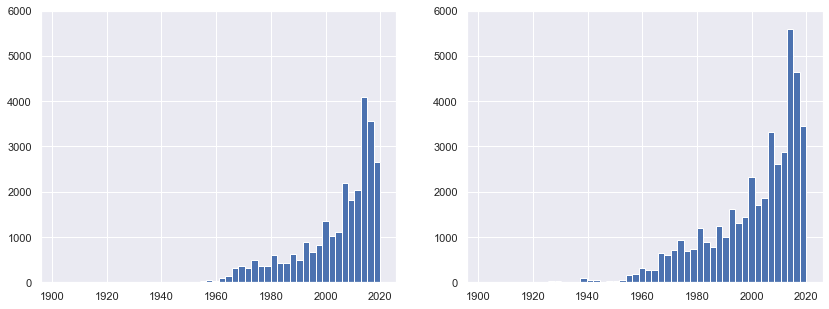

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].hist(before_annotation, bins=50)
ax[0].set_ylim(top=6000)
ax[1].hist(lyrics_df.loc[:, "year"], bins=50)
ax[1].set_ylim(top=6000)
plt.show()

In [45]:
lyrics_df.loc[lyrics_df.year < 1980, :].shape

(5957, 7)

In [46]:
lyrics_df.loc[(lyrics_df.year >= 1980) & (lyrics_df.year < 2000), :].shape

(10239, 7)

In [47]:
lyrics_df.loc[(lyrics_df.year >= 2000) & (lyrics_df.year < 2010), :].shape

(9787, 7)

In [48]:
lyrics_df.loc[(lyrics_df.year >= 2010) & (lyrics_df.year <= 2020), :].shape

(17861, 7)

# WRITE CLEANED DATASET 

In [49]:
lyrics_df.shape

(43844, 7)

In [50]:
lyrics_df = lyrics_df.astype({"artist": str, "song": str, "album": str, 
                             "release_date": str, "genre": str, "lyrics": str, "year": int})

In [51]:
lyrics_df.to_csv("./data/lyrics_cleaned.csv", index=False)